In [1]:
import pandas as pd
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(["M", "B"])

array([1, 0])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 1)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline #処理の連結が可能に

pipe_lr = make_pipeline(StandardScaler(), #複数の変換器と一つの推定器が連結できる
                        PCA(n_components = 2), 
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.956


In [6]:
#層化k分割交差検証
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"Fold: {k+1:02d}", 
         f"Class distr.: {np.bincount(y_train[train])}", 
         f"Acc.: {score: .3f}")

Fold: 01 Class distr.: [256 153] Acc.:  0.935
Fold: 02 Class distr.: [256 153] Acc.:  0.935
Fold: 03 Class distr.: [256 153] Acc.:  0.957
Fold: 04 Class distr.: [256 153] Acc.:  0.957
Fold: 05 Class distr.: [256 153] Acc.:  0.935
Fold: 06 Class distr.: [257 153] Acc.:  0.956
Fold: 07 Class distr.: [257 153] Acc.:  0.978
Fold: 08 Class distr.: [257 153] Acc.:  0.933
Fold: 09 Class distr.: [257 153] Acc.:  0.956
Fold: 10 Class distr.: [257 153] Acc.:  0.956


In [7]:
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f"CV accuracy: {mean_acc: .3f} +/- {std_acc: .3f}") #cross-validation

CV accuracy:  0.950 +/-  0.014


In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, 
                        X = X_train, y = y_train, 
                        cv = 10, n_jobs = 1) #n_jobsの指定により複数のCPUによる並列処理が可能
print(f"CV accuracy scores: {scores}")

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [9]:
print(f"CV accuracy: {np.mean(scores): .3f} +/- {np.std(scores): .3f}")

CV accuracy:  0.950 +/-  0.014


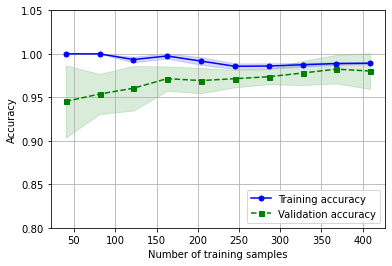

In [10]:
#学習曲線
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty = "l2", max_iter = 10000))

train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr, X = X_train, y = y_train, 
                                                       train_sizes = np.linspace(0.1, 1.0, 10), cv = 10, n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, color = "blue", marker = "o", markersize = 5, label = "Training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = "blue")
plt.plot(train_sizes, test_mean, color = "green", linestyle = "--", marker = "s", markersize = 5, label = "Validation accuracy")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = "green")
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.ylim([0.8, 1.05])
plt.show()

n<250ではテストとの正解率に開きがあるため、過学習の兆候

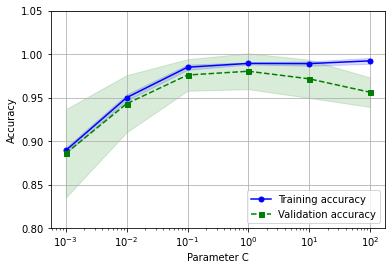

In [11]:
#検証曲線
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator = pipe_lr, X = X_train, y = y_train, 
                                              param_name = "logisticregression__C", param_range = param_range, cv = 10)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, color = "blue", marker = "o", markersize = 5, label = "Training accuracy")
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = "blue")
plt.plot(param_range, test_mean, color = "green", linestyle = "--", marker = "s", markersize = 5, label = "Validation accuracy")
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = "green")
plt.grid()
plt.xscale("log")
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.ylim([0.8, 1.05])
plt.show()

C>10あたりから過学習の兆候

In [29]:
#グリッドサーチ
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state = 1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
#線形SVMとカーネルSVMの評価を辞書のリストで渡す
param_grid = [{"svc__C" : param_range, "svc__kernel" : ["linear"]}, 
             {"svc__C" : param_range, "svc__gamma" : param_range, "svc__kernel" : ["rbf"]}]

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = "accuracy", cv = 10, refit = True, n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [13]:
clf = gs.best_estimator_
clf.fit(X_train, y_train) #gsのrefit= Trueのため既にデータセット全体で再訓練済なのでいらない処理
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

Test accuracy: 0.974


In [14]:
#ランダムサーチ
import scipy
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state = 1))
param_range = scipy.stats.loguniform(0.0001, 1000.0) #対数一様分布
param_grid = [{"svc__C" : param_range, "svc__kernel" : ["linear"]}, 
             {"svc__C" : param_range, "svc__gamma" : param_range, "svc__kernel" : ["rbf"]}]

rs = RandomizedSearchCV(estimator = pipe_svc, param_distributions = param_grid, scoring = "accuracy", 
                        n_iter = 20, cv = 10, refit = True, random_state = 1, n_jobs = -1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9780676328502416
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


In [36]:
#Successive Halving
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_range = scipy.stats.loguniform(0.0001, 1000.0).rvs(20)
param_grid = [{"svc__C" : param_range, "svc__kernel" : ["linear"]}, 
             {"svc__C" : param_range, "svc__gamma" : param_range, "svc__kernel" : ["rbf"]}]

hs = HalvingGridSearchCV(pipe_svc, param_grid = param_grid, min_resources = "exhaust",
                         resource = "n_samples", factor = 1.5, random_state = 1, n_jobs = -1)

In [37]:
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

clf = hs.best_estimator_
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

0.9705882352941178
{'svc__C': 216.8703276659237, 'svc__gamma': 0.003058634689091416, 'svc__kernel': 'rbf'}
Test accuracy: 0.974


In [39]:
#入れ子の交差検証
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{"svc__C" : param_range, "svc__kernel" : ["linear"]},
              {"svc__C" : param_range, "svc__gamma" : param_range, "svc__kernel" : ["rbf"]}]

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = "accuracy", cv = 2)
scores = cross_val_score(gs, X_train, y_train, scoring = "accuracy", cv = 5)
print(f"CV accuracy: {np.mean(scores):.3f} " f"+/- {np.std(scores):.3f}")

CV accuracy: 0.974 +/- 0.015


In [41]:
#決定木と比較
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                  param_grid = [{"max_depth" : [1,2,3,4,5,6,7,None]}], scoring = "accuracy", cv = 2)
scores = cross_val_score(gs, X_train, y_train, scoring = "accuracy", cv = 5)
print(f"CV accuracy: {np.mean(scores):.3f} " f"+/- {np.std(scores):.3f}")

CV accuracy: 0.934 +/- 0.016


In [43]:
#混同行列
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


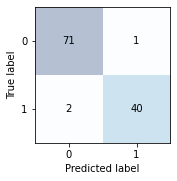

In [45]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j], va = "center", ha = "center")
ax.xaxis.set_ticks_position("bottom")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true = y_test, y_pred = y_pred) #適合率=TP/(TP+FP)
print(f"Precision: {pre_val:.3f}")

rec_val = recall_score(y_true = y_test, y_pred = y_pred) #再現率=TP/(FN+TP)
print(f"Recall: {rec_val:.3f}")

f1_val = f1_score(y_true = y_test, y_pred = y_pred) #F1スコア
print(f"F1: {f1_val:.3f}")

mcc_val = matthews_corrcoef(y_true = y_test, y_pred = y_pred) #マシューズ相関係数
print(f"MCC: {mcc_val:.3f}")

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


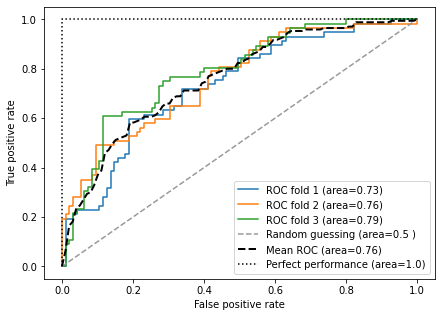

In [57]:
#ROC曲線
from sklearn.metrics import roc_curve, auc #AUC:曲線下面積
from numpy import interp #線形補完

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components = 2), LogisticRegression(penalty = "l2",
                        random_state = 1, solver = "lbfgs", C = 100.0))
X_train2 = X_train[:, [4, 14]] #訓練に使用する特徴量を２つだけに
cv = list(StratifiedKFold(n_splits = 3).split(X_train, y_train))
fig = plt.figure(figsize =(7, 5))
mean_tpr = 0.0 #真陽性率（y軸）
mean_fpr = np.linspace(0, 1, 100) #偽陽性率（x軸）
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test]) #各クラスに所属する確率
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label = 1)
    mean_tpr += interp(mean_fpr, fpr, tpr) #0.01間隔でtprの値を線形補完
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f"ROC fold {i + 1} (area={roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], linestyle = "--", color = (0.6, 0.6, 0.6), label = "Random guessing (area=0.5 )") #当て推量をプロット

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label = f"Mean ROC (area={mean_auc:.2f})", lw = 2)
plt.plot([0,0,1], [0,1,1], linestyle = ":", color = "black", label = "Perfect performance (area=1.0)") #理想の分類器をプロット

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc = "lower right")
plt.show()